# Un premier graphe de compositeurs

In [3]:
from bs4 import BeautifulSoup
import requests
import re
import networkx as nx
import spacy
import time

## Variables globales

In [12]:
#Dictionnaire des propriétés souhaitées
dico_props = {"pays" : "P27",
              "nom" : "P735",
              "prenom" : "P734",
              "date de naissance" : "P569",
              "genre" : "P136",
              "influences" : "P737",
              "oeuvres":"P800",
              "religion" : "P140",
              "étudiant de" : "P1066",
              "professeur de": "P802",
              "écoles" : "P69",
              "domaines" : "P101",
              "institut" : "P108",
              "début de carrière" : "P2031",
              "langues" : "P1412",
              "lieux de vie" : "P551",
              "mouvement" : "P135",
              "métiers" : "P106"}

In [68]:
def find_id(name):
    """Récupère l'id d'un compositeur à partir de son nom"""
    url = f"https://www.wikidata.org/w/index.php?search={name[0]}+{name[1]}&title=Special%3ASearch&ns0=1&ns120=1"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    bloc = soup.find("div", class_ = "mw-search-result-heading")
    group = bloc.find("a")
    if group is None:
        return None
    else:
        return group["href"][6:]

In [8]:
find_id(("Johann-Sebastian","Bach"))

'Q1339'

## Récupération des noms depuis Classic Cat

In [5]:
url = requests.get("https://www.classiccat.net/composers.php")
page = BeautifulSoup(url.content, "html.parser")
li_compo = page.find_all("a", href = True)
compos = []
for lien in li_compo:
    text = lien.get_text()
    if "," in text:
        if len(compos)>0:
            if text[0] < compos[-1][0]:
                break
        compos.append(text)


In [6]:
composers = [(compo.split(",")[1],compo.split(",")[0])  for compo in compos]

## Complétion des données à partir de l'endpoint Sparqle de Wikidata

In [15]:
def actualise_prop(dico,prop,nameprop,id):
    """Actualise le dictionnaire avec la propriété prop"""
    sparql_endpoint = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?prop ?propLabel WHERE {{
        wd:{id} wdt:{prop} ?prop.
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }}
    }}
    """
    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'})
    time.sleep(0.05)
    li_rep = []
    if response.status_code == 200:
        data = response.json()
        for item in data['results']['bindings']:
            li_rep.append((item['prop']['value'][31:],item['propLabel']['value']))
        dico[nameprop] = li_rep
    else:
        dico[nameprop] = None
        print("Erreur lors de la requête SPARQL:", response.status_code)

In [22]:
name = ("Johann-Sebastian","Bach")
id = find_id(name)
dico = {}
actualise_prop(dico,'P27','pays',id)
dico

{'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')]}

In [9]:
def create_profile(name,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son nom"""
    dico = {"prénom" : name[0], "nom" : name[1]}
    id = find_id(name)
    dico["id"] = id
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [23]:
create_profile(("Johann-Sebastian","Bach"),dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'prénom': 'Johann-Sebastian',
 'nom': 'Bach',
 'id': 'Q1339',
 'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')],
 'date de naissance': [('', '1685-03-31T00:00:00Z')],
 'genre': [('Q8361', 'musique baroque')],
 'influences': [('Q1340', 'Antonio Vivaldi'),
  ('Q76485', 'Johann Pachelbel'),
  ('Q508635', 'Johann Georg Pisendel')],
 'oeuvres': [('Q75464', 'Sonates et partitas pour violon seul'),
  ('Q208224', 'concertos brandebourgeois'),
  ('Q211971', 'Le Clavier bien tempéré'),
  ('Q213728', 'Variations Goldberg'),
  ('Q310549', 'Messe en si mineur'),
  ('Q379111', 'Passion selon Saint Matthieu'),
  ('Q392734', 'Toccata et fugue en ré mineur'),
  ('Q465878', "L'Art de la fugue"),
  ('Q642010', 'Oratorio de Noël'),
  ('Q693675', "L'Offrande musicale"),
  ('Q756843', 'Suites pour violoncelle seul'),
  ('Q865333', 'Passion selon saint Jean'),
  ('Q892166', 'Jesu, meine Freude'),
  ('Q908241', 'Sonates en trio pour orgue de Bach'),
  ('Q1053305

In [16]:
def create_profile_id(id,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son id"""
    dico = {"id" : id}
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [17]:
create_profile_id("Q38193",dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'id': 'Q38193',
 'pays': [('Q27306', 'Royaume de Prusse')],
 'nom': [('Q1778168', 'Arthur')],
 'prenom': [('Q27498082', 'Schopenhauer')],
 'date de naissance': [('', '1788-02-22T00:00:00Z')],
 'genre': [],
 'influences': [('Q859', 'Platon'),
  ('Q5879', 'Johann Wolfgang von Goethe'),
  ('Q9312', 'Emmanuel Kant'),
  ('Q9353', 'John Locke'),
  ('Q35802', 'Baruch Spinoza'),
  ('Q37160', 'David Hume')],
 'oeuvres': [('Q560352', 'Le Monde comme Volonté et comme Représentation'),
  ('Q929229', 'Parerga et Paralipomena')],
 'religion': [('Q7066', 'athéisme')],
 'étudiant de': [],
 'professeur de': [],
 'écoles': None,
 'domaines': None,
 'institut': None,
 'début de carrière': [],
 'langues': None,
 'lieux de vie': None,
 'mouvement': None,
 'métiers': [('Q36180', 'écrivain ou écrivaine'),
  ('Q333634', 'traducteur ou traductrice'),
  ('Q1622272', "professeur ou professeure d'université"),
  ('Q4964182', 'philosophe'),
  ('Q14915627', 'musicologue')]}

## Complétion plus rapide à l'aide de l'API Wikipedia

In [145]:
def find_all_properties(entity_id,dico_props = None,lg = "fr"):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids={entity_id}"
    response = requests.get(url)
    properties = {"id" : entity_id}
    if response.status_code == 200:
        data = response.json()
        data2 = data['entities'][entity_id]
        if 'labels' in data2 and lg in data2['labels']:
            name = data2['labels'][lg]['value']
        else:
            name = data2['labels']['en']['value']
        properties["nom"] = name
        if 'descriptions' in data2 and lg in data2['descriptions']:
            desc = data2['descriptions'][lg]['value']
        else:
            desc = data2['descriptions']['en']['value']
        properties["description"] = desc
        claims = data['entities'][entity_id]['claims']
        for prop in claims:
            if prop.startswith("P"):
                if dico_props is None or prop in dico_props.values():
                    if len(claims[prop]) > 0:
                        properties[prop] = []
                        for item in claims[prop]:
                            if 'mainsnak' in item and 'datavalue' in item['mainsnak']:
                                value = item['mainsnak']['datavalue']
                                if value['type'] == 'wikibase-entityid':
                                    properties[prop].append(value['value']['id'])
                                elif value['type'] == 'string':
                                    properties[prop].append(value['value'])
                                elif value['type'] == 'time':
                                    properties[prop].append(value['value']['time'])
                                elif value['type'] == 'quantity':
                                    properties[prop].append(value['value']['amount'])
                                elif value['type'] == 'globe-coordinate':
                                    properties[prop].append((value['value']['latitude'], value['value']['longitude']))
                                else:
                                    properties[prop].append(value['value'])
        if dico_props is not None:
            proprietes = {"id" : entity_id, "nom complet" : name, "description" : desc}
            for name, prop in dico_props.items():
                if prop in properties:
                    proprietes[name] = properties[prop]
            return proprietes
        return properties
    else:
        print(f"Erreur lors de la récupération des propriétés : {response.status_code}")
        return None

In [146]:
dico = find_all_properties(find_id(("Richard","Wagner")), dico_props=dico_props)
dico

{'id': 'Q1511',
 'nom complet': 'Richard Wagner',
 'description': "compositeur, directeur de théâtre, écrivain, chef d'orchestre et polémiste allemand de la période romantique",
 'pays': ['Q153015', 'Q183', 'Q39', 'Q38', 'Q40'],
 'nom': ['Q1249148', 'Q11027623'],
 'prenom': ['Q2539239'],
 'date de naissance': ['+1813-05-22T00:00:00Z', '+1813-00-00T00:00:00Z'],
 'genre': ['Q1344', 'Q2142754', 'Q9730'],
 'influences': ['Q38193'],
 'oeuvres': ['Q114640', 'Q1324254', 'Q560619', 'Q327717', 'Q23085', 'Q190237'],
 'religion': ['Q75809'],
 'étudiant de': ['Q65815'],
 'professeur de': ['Q594113'],
 'écoles': ['Q154804', 'Q1526368', 'Q699668'],
 'domaines': ['Q1344', 'Q279272'],
 'institut': ['Q686522'],
 'début de carrière': ['+1832-00-00T00:00:00Z'],
 'langues': ['Q188'],
 'métiers': ['Q36834',
  'Q8178443',
  'Q158852',
  'Q11774202',
  'Q3387717',
  'Q18814623',
  'Q49757',
  'Q486748',
  'Q1350157',
  'Q18939491',
  'Q36180']}

## Génération du graphe d'influences

Compositeurs à traiter à l'étape 0/5 : {'Q254'}
Etude de Q254
Les voisins de Q254 : ['Q311378', 'Q1339']
Ajout de Q311378 dans le graphe
Ajout de Q1339 dans le graphe
Compositeurs à traiter à l'étape 1/5 : {'Q1339', 'Q311378'}
Etude de Q1339
Les voisins de Q1339 : ['Q1340', 'Q76485', 'Q508635']
Ajout de Q1340 dans le graphe
Ajout de Q76485 dans le graphe
Ajout de Q508635 dans le graphe
Etude de Q311378
Compositeurs à traiter à l'étape 2/5 : {'Q508635', 'Q76485', 'Q1340'}
Etude de Q508635
Etude de Q76485
Etude de Q1340
Les voisins de Q1340 : ['Q164475', 'Q207532']
Ajout de Q164475 dans le graphe
Ajout de Q207532 dans le graphe
Compositeurs à traiter à l'étape 3/5 : {'Q207532', 'Q164475'}
Etude de Q207532
Etude de Q164475
Compositeurs à traiter à l'étape 4/5 : set()


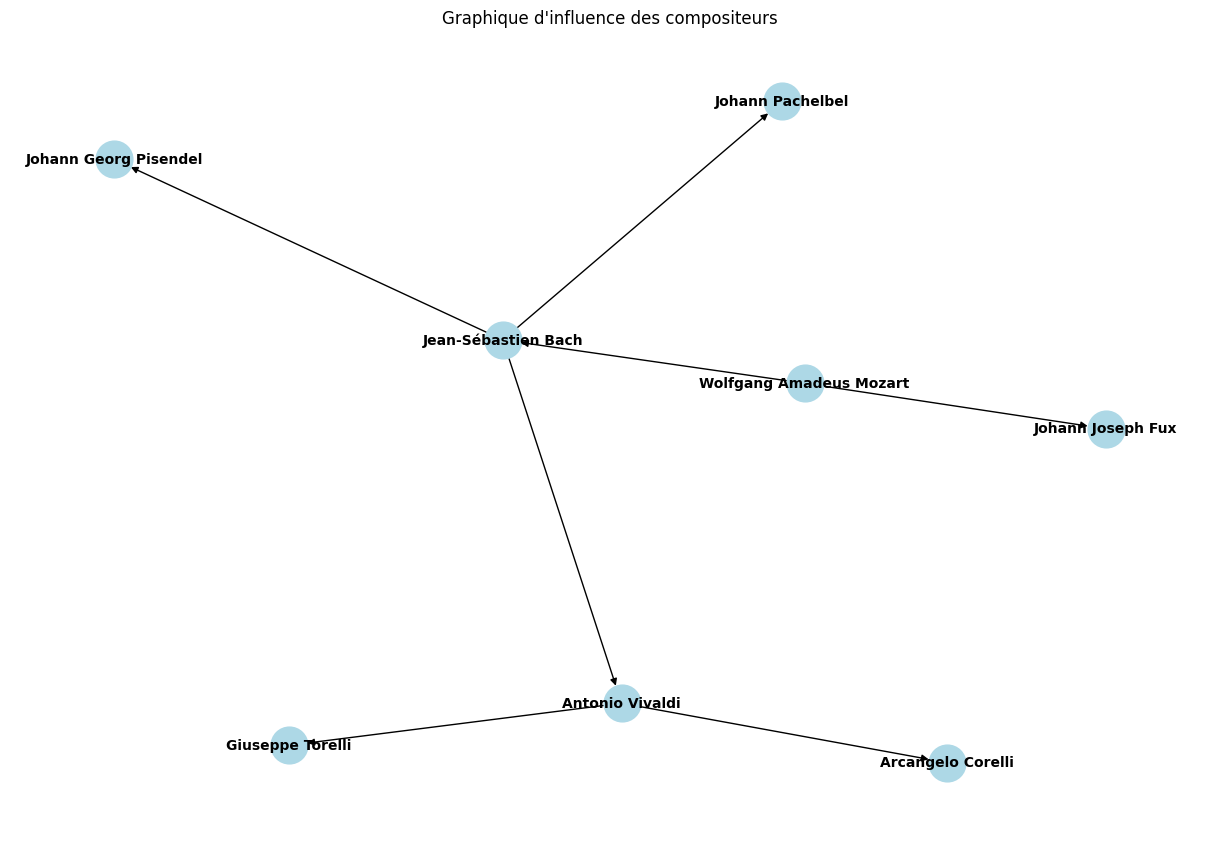

In [155]:
def graph_influence(id_composer,n_max_iter=2):
    G = nx.DiGraph()
    properties = find_all_properties(id_composer, dico_props=dico_props)
    G.add_node(id_composer, **properties)
    set_actuel = {id_composer}
    visites = {id_composer: properties}
    for i in range(n_max_iter):
        set_suivant = set()
        print(f"Compositeurs à traiter à l'étape {i}/{n_max_iter} : {set_actuel}")
        for id_influ in set_actuel:
            print(f"Etude de {id_influ}")
            if visites[id_influ] is not None and "influences" in visites[id_influ].keys():
                influences = visites[id_influ]["influences"]
                print(f"Les voisins de {id_influ} : {influences}")
                if influences is not None:
                    for id_suivant in influences:
                        if id_suivant not in visites.keys():
                            print(f"Ajout de {id_suivant} dans le graphe")
                            dico = find_all_properties(id_suivant, dico_props=dico_props)
                            G.add_node(id_suivant, **dico)
                            visites[id_suivant] = dico
                        else:
                            print(f"{id_suivant} déjà présent dans le graphe")
                        G.add_edge(id_influ, id_suivant)
                        set_suivant.add(id_suivant)
        set_actuel = set_suivant.copy()
    for node in G.nodes():
        if node in visites.keys():
            G.nodes[node].update(visites[node])
        else:
            print("Erreur !")
    return G

graph = graph_influence(find_id(("Wolfgang Amadeus","Mozart")), n_max_iter=5)

def draw_graph(graph):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(graph, seed=42)  # Positionnement des nœuds
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, labels = nx.get_node_attributes(graph, 'nom complet'), node_size=700, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    plt.title("Graphique d'influence des compositeurs")
    plt.show()
draw_graph(graph)